##Downloading data

In [ ]:
import os
from google.colab import auth

project_id = 'doc-localization-al'

train_folder = 'smartDocData_DocTrainC.zip'
test_folder = 'smartDocData_DocTestC.zip'
train_lab = 'gt-train.csv'
test_lab = 'gt-test.csv'
to_download = [train_folder, test_folder, train_lab, test_lab, 'utils.py']
tmp = 'data'


auth.authenticate_user()
os.system(f'gcloud config set project {project_id}')
os.system(f'mkdir /content/{tmp}')

for s in to_download:
  os.system(f'gsutil cp gs://doc-local-data/{s} /content/{tmp}/{s}')
  
!unzip /content/{tmp}/{train_folder} -d /content/{tmp}/
!unzip /content/{tmp}/{test_folder} -d /content/{tmp}/


Streaming output truncated to the last 5000 lines.
  inflating: /content/data/smartDocData_DocTestC/background02magazine005.avi103.jpg  
  inflating: /content/data/smartDocData_DocTestC/background01patent005.avi112.jpg  
  inflating: /content/data/smartDocData_DocTestC/background04patent005.avi060.jpg  
  inflating: /content/data/smartDocData_DocTestC/background01tax003.avi119.jpg  
  inflating: /content/data/smartDocData_DocTestC/background01tax005.avi072.jpg  
  inflating: /content/data/smartDocData_DocTestC/background04datasheet005.avi049.jpg  
  inflating: /content/data/smartDocData_DocTestC/background01tax005.avi066.jpg  
  inflating: /content/data/smartDocData_DocTestC/background01patent005.avi106.jpg  
  inflating: /content/data/smartDocData_DocTestC/background04patent005.avi074.jpg  
  inflating: /content/data/smartDocData_DocTestC/background02magazine005.avi117.jpg  
  inflating: /content/data/smartDocData_DocTestC/background01tax002.avi203.jpg  
  inflating: /content/data/sma

Loading data

In [ ]:
train_sz = len(os.listdir('/content/data/smartdocData_DocTrainC'))-1
test_sz = len(os.listdir('/content/data/smartDocData_DocTestC'))-1
print(train_sz, test_sz)

16765 6158


In [ ]:
import numpy as np
import csv
import time
import cv2
from IPython.display import clear_output

class LoadingBar():
  def __init__(self, len):
    self.bar = list('[' + ' '*50 + ']')
    self.stepsz = len/50
    self.ind = 1
  
  def step(self, place):
    if(int(place%self.stepsz)==0):
      self.bar[self.ind] = '='
      if(self.ind<50):
        self.bar[self.ind+1] = '>'
        self.ind = self.ind+1
      clear_output(wait=True)
      print(''.join(self.bar))

class Dataset():
  def __init__(self, directory, labels, size):
    self.data=np.empty((size,64,64,3), dtype=np.uint8)
    self.coords=np.empty((size,8))

    dat = open(labels,newline='\n')
    datr = csv.reader(dat)
    counter = 0
    start = time.time()
    br = LoadingBar(size)
    for row in datr:
      img = cv2.imread(os.path.join(directory,row[0]))
      img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
      
      self.data[counter] = img
      self.coords[counter] = np.array(row[1:]).astype('float')
      br.step(counter)
      counter += 1
    dat.close()
    print(f'{size} units loaded in {time.time()-start} seconds')

In [ ]:
trainData = Dataset('/content/data/smartdocData_DocTrainC','/content/data/gt-train.csv',train_sz)

[==================================================]
16765 units loaded in 2.2870934009552 seconds


In [ ]:
testData = Dataset('/content/data/smartDocData_DocTestC','/content/data/gt-test.csv', test_sz)

[==================================================]
6158 units loaded in 1.0241448879241943 seconds


Seeing if loading worked

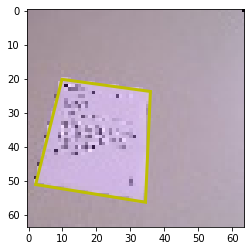

In [ ]:
os.chdir('/content/data')
from utils import *
import numpy as np
sample_img, sample_pts = trainData.data[0], trainData.coords[0]

#coordinates are normalized to be 0-1, to get actual coordinates multiply by 64
sample_pts = np.reshape(sample_pts,(4,2))*64 

plot_with_box(sample_img, sample_pts)

In [ ]:
#Data augmentation
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential

#change so no weird rotations
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomContrast(0.25),
  tf.keras.layers.RandomBrightness(0.25)
])

## Loading pre-trained ResNet 18
<br>
https://github.com/qubvel/classification_models

In [ ]:
!pip install image-classifiers==1.0.0b1
!pip install keras_applications==1.0.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0b1-py3-none-any.whl size=19968 sha256=7c98e8b1302e1a375b427465f3244375c6852ed39b6bc6dbedd849f15dbaa3b9
  Stored in directory: /root/.cache/pip/wheels/59/ee/99/bdd974449ed4653c3c2e37d600817c9da816057dfa43c67878
Successfully built image-classifiers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 683 kB/s 


In [ ]:
import keras
from classification_models.keras import Classifiers

ResNet18, preprocess_input = Classifiers.get('resnet18')

# prepare your data
X = trainData.data
y = trainData.coords

from sklearn.model_selection import train_test_split

X_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=16)


# build model
base_model = ResNet18(input_shape=(64,64,3), weights='imagenet', include_top=False)

44920640/44920640 [==============================] - 1s 0us/step


Modifying model for localization

In [ ]:
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

#Regression head, 8 coordinates
prediction_layer = tf.keras.layers.Dense(8, activation='relu')

In [ ]:
#Building model
inputs = tf.keras.Input(shape=(64, 64, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
outputs = prediction_layer(x)
model2 = tf.keras.Model(inputs, outputs)

In [ ]:
#compile model
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.MeanSquaredError(),#Use MSE for regression
              metrics=['accuracy'])

##Model training

##No fine-tuning

In [ ]:
initial_epochs = 10
loss0, accuracy0 = model2.evaluate(x=testData.data, y=testData.coords)
#initial metrics
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

193/193 [==============================] - 2s 9ms/step - loss: 0.9675 - accuracy: 0.2340
initial loss: 0.97
initial accuracy: 0.23


In [ ]:
initial_epochs = 10

history1 = model2.fit(x=X_train, y=y_train,
                    epochs=initial_epochs, validation_data = (x_val, y_val))

Epoch 1/10


393/393 [==============================] - 68s 165ms/step - loss: 0.2674 - accuracy: 0.2738 - val_loss: 0.1440 - val_accuracy: 0.2758
Epoch 2/10
393/393 [==============================] - 63s 162ms/step - loss: 0.1355 - accuracy: 0.3327 - val_loss: 0.0671 - val_accuracy: 0.4857
Epoch 3/10
393/393 [==============================] - 64s 164ms/step - loss: 0.0661 - accuracy: 0.4227 - val_loss: 0.0460 - val_accuracy: 0.5494
Epoch 4/10
393/393 [==============================] - 63s 160ms/step - loss: 0.0486 - accuracy: 0.5351 - val_loss: 0.0442 - val_accuracy: 0.6138
Epoch 5/10
393/393 [==============================] - 63s 161ms/step - loss: 0.0462 - accuracy: 0.5793 - val_loss: 0.0436 - val_accuracy: 0.6305
Epoch 6/10
393/393 [==============================] - 64s 163ms/step - loss: 0.0459 - accuracy: 0.5840 - val_loss: 0.0430 - val_accuracy: 0.6691
Epoch 7/10
393/393 [==============================] - 63s 160ms/step - loss: 0.0454 - accuracy: 0.5779 - val_loss: 0.0433 - val_accuracy: 0.6

In [ ]:
#to calculate IoU properly later
preds0 = model2.predict(x=testData.data)

193/193 [==============================] - 2s 7ms/step


In [ ]:
#save predictions
import pandas as pd

outfile0 = 'predictions_nft.csv'

output_file = open(outfile0, 'w')

df0 = pd.DataFrame(preds0)
df0.to_csv(outfile0, index = False)
print("Written to csv file {}".format(outfile0))

Written to csv file predictions_nft.csv


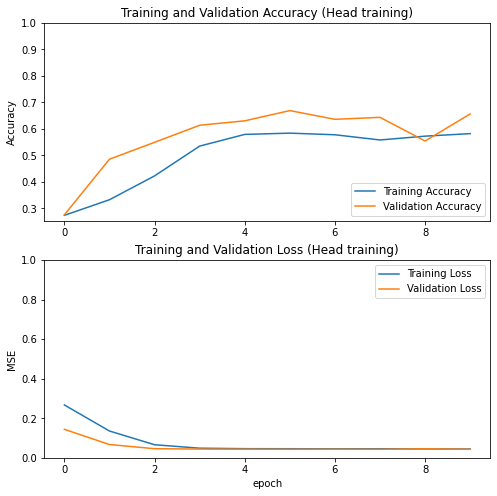

In [ ]:
import matplotlib.pyplot as plt

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy (Head training)')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss (Head training)')
plt.xlabel('epoch')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#save trained model weights
model2.save_weights('/content/drive/MyDrive/NYU4/NYU4.1_MDL/DS301-Final-project/model_products/model0_wts')

ValueError: ignored

###Partial fine-tuning

In [ ]:
base_model1 = ResNet18(input_shape=(64,64,3), weights='imagenet', include_top=False)

len(base_model1.layers)

86

In [ ]:
base_model1.trainable = True

#fine tune last 8 layers
fine_tune_at = len(base_model1.layers)-8

#freeze all layers before fine_tune_at
for layer in base_model1.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

#Regression head, 8 coordinates
prediction_layer = tf.keras.layers.Dense(8, activation='relu')

#Building model
inputs = tf.keras.Input(shape=(64, 64, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model1(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
outputs = prediction_layer(x)
pft_model = tf.keras.Model(inputs, outputs)

#compile model (lower learning rate for fine-tuning)
base_learning_rate = 0.001
pft_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/100),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10

pft_history = pft_model.fit(x=X_train, y=y_train,
                    epochs=initial_epochs, validation_data = (x_val, y_val))

Epoch 1/10


393/393 [==============================] - 87s 192ms/step - loss: 0.2842 - accuracy: 0.2409 - val_loss: 0.1539 - val_accuracy: 0.3325
Epoch 2/10
393/393 [==============================] - 67s 171ms/step - loss: 0.1303 - accuracy: 0.3242 - val_loss: 0.0647 - val_accuracy: 0.3745
Epoch 3/10
393/393 [==============================] - 65s 165ms/step - loss: 0.0650 - accuracy: 0.3638 - val_loss: 0.0390 - val_accuracy: 0.4370
Epoch 4/10
393/393 [==============================] - 64s 164ms/step - loss: 0.0396 - accuracy: 0.4017 - val_loss: 0.0201 - val_accuracy: 0.4814
Epoch 5/10
393/393 [==============================] - 67s 170ms/step - loss: 0.0262 - accuracy: 0.4405 - val_loss: 0.0130 - val_accuracy: 0.5107
Epoch 6/10
393/393 [==============================] - 65s 167ms/step - loss: 0.0204 - accuracy: 0.4529 - val_loss: 0.0103 - val_accuracy: 0.5425
Epoch 7/10
393/393 [==============================] - 65s 166ms/step - loss: 0.0174 - accuracy: 0.4716 - val_loss: 0.0079 - val_accuracy: 0.5

###Partial fine-tuning training metrics

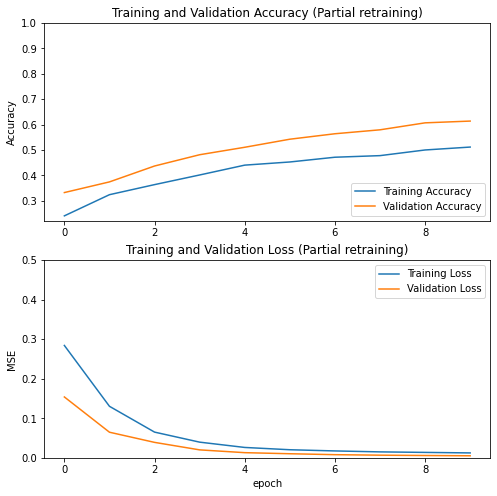

In [ ]:
import matplotlib.pyplot as plt

acc = pft_history.history['accuracy']
val_acc = pft_history.history['val_accuracy']

loss = pft_history.history['loss']
val_loss = pft_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy (Partial retraining)')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.ylim([0,0.5])
plt.title('Training and Validation Loss (Partial retraining)')
plt.xlabel('epoch')
plt.show()

In [ ]:
pft_model.save_weights('/content/drive/MyDrive/NYU4/NYU4.1_MDL/DS301-Final-project/model_products/pft_model_wts')

In [ ]:
import tensorflow as tf
pft_model.load_weights('/content/drive/MyDrive/NYU4/NYU4.1_MDL/DS301-Final-project/model_products/pft_model_wts')

In [ ]:
#generate predictions
predictions1 = pft_model.predict(testData.data)

193/193 [==============================] - 9s 8ms/step


In [ ]:
len(predictions1) == len(testData.coords)

True

In [ ]:
#save predictions
import pandas as pd

outfile1 = 'predictions_pft.csv'

output_file = open(outfile1, 'w')

df1 = pd.DataFrame(predictions1)
df1.to_csv(outfile1, index = False)
print("Written to csv file {}".format(outfile1))

Written to csv file predictions_pft.csv


##Full model retraining

In [ ]:
base_model3 = ResNet18(input_shape=(64,64,3), weights='imagenet', include_top=False)
base_model3.trainable = True

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

#Regression head, 8 coordinates
prediction_layer = tf.keras.layers.Dense(8, activation='relu')

#Building model
inputs = tf.keras.Input(shape=(64, 64, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model3(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
outputs = prediction_layer(x)
model3 = tf.keras.Model(inputs, outputs)

#compile model
base_learning_rate = 0.001
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/100),
              loss=tf.keras.losses.MeanSquaredError(),#Use MSE for regression
              metrics=['accuracy'])

In [ ]:
history3 = model3.fit(x=X_train, y=y_train,
                    epochs=initial_epochs, validation_data = (x_val, y_val))

Epoch 1/10


393/393 [==============================] - 80s 192ms/step - loss: 0.1056 - accuracy: 0.3228 - val_loss: 0.0148 - val_accuracy: 0.4936
Epoch 2/10
393/393 [==============================] - 75s 190ms/step - loss: 0.0193 - accuracy: 0.4435 - val_loss: 0.0095 - val_accuracy: 0.6202
Epoch 3/10
393/393 [==============================] - 74s 188ms/step - loss: 0.0151 - accuracy: 0.5025 - val_loss: 0.0079 - val_accuracy: 0.6749
Epoch 4/10
393/393 [==============================] - 75s 190ms/step - loss: 0.0111 - accuracy: 0.5328 - val_loss: 0.0035 - val_accuracy: 0.7114
Epoch 5/10
393/393 [==============================] - 74s 188ms/step - loss: 0.0089 - accuracy: 0.5564 - val_loss: 0.0030 - val_accuracy: 0.7400
Epoch 6/10
393/393 [==============================] - 75s 190ms/step - loss: 0.0079 - accuracy: 0.5804 - val_loss: 0.0021 - val_accuracy: 0.7717
Epoch 7/10
393/393 [==============================] - 74s 188ms/step - loss: 0.0070 - accuracy: 0.6095 - val_loss: 0.0018 - val_accuracy: 0.7

###Full fine-tuning training metrics

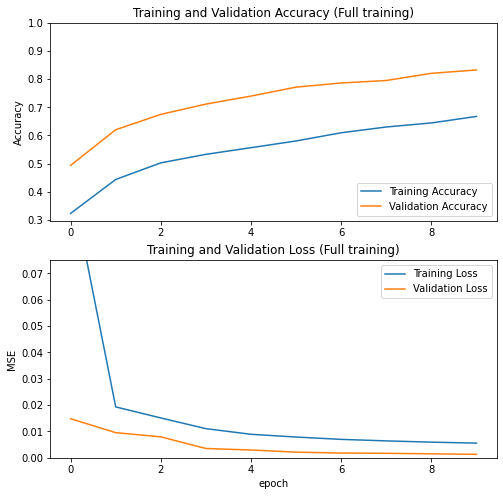

In [ ]:
import matplotlib.pyplot as plt

acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy (Full training)')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.ylim([0,0.075])
plt.title('Training and Validation Loss (Full training)')
plt.xlabel('epoch')
plt.show()

In [ ]:
model3.save_weights('/content/drive/MyDrive/NYU4/NYU4.1_MDL/DS301-Final-project/model_products/model3_t2_wts')

In [ ]:
#generate predictions
predictions3 = model3.predict(testData.data)

193/193 [==============================] - 2s 7ms/step


In [ ]:
#save predictions
import pandas as pd

outfile3 = 'predictions_fft.csv'

output_file = open(outfile3, 'w')

df3 = pd.DataFrame(predictions3)
df3.to_csv(outfile3, index = False)
print("Written to csv file {}".format(outfile3))

Written to csv file predictions_fft.csv
